In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v011.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/anat_mask.nc
Loading ../data/NAFLD/0006/mre_mask.nc
100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


<IPython.core.display.Javascript object>


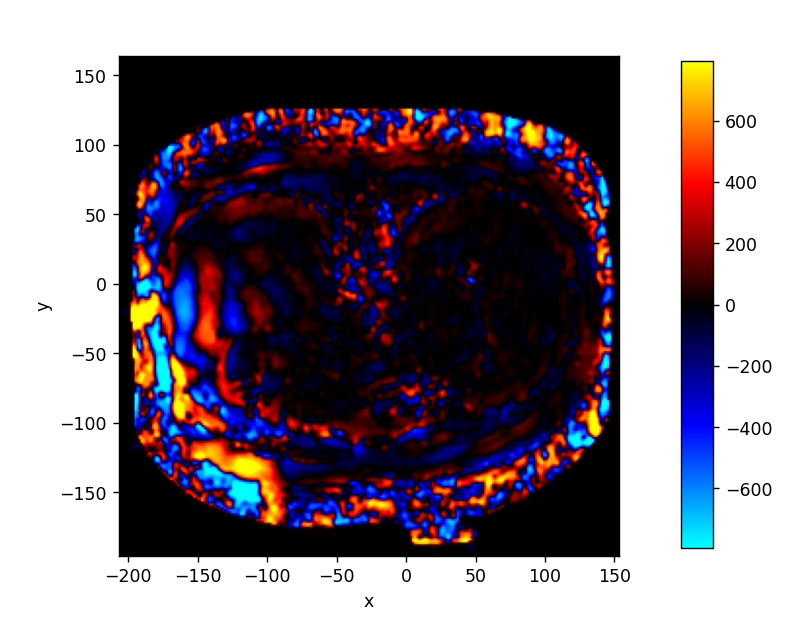

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [3]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids=['0006'], xarray_dir='../data/NAFLD')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-11-7.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
#cohort.eval_baseline()
cohort[0].view(['wave'])

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data



<IPython.core.display.Javascript object>


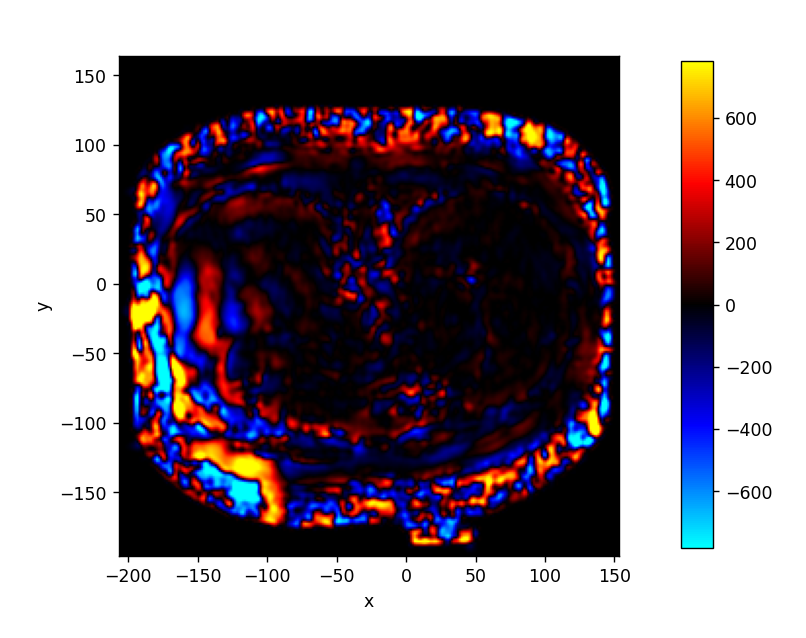

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


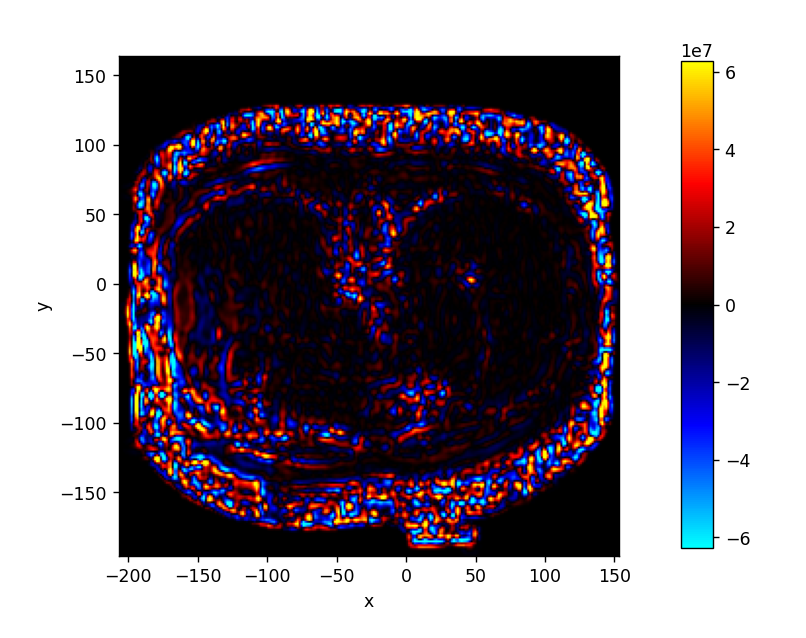

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


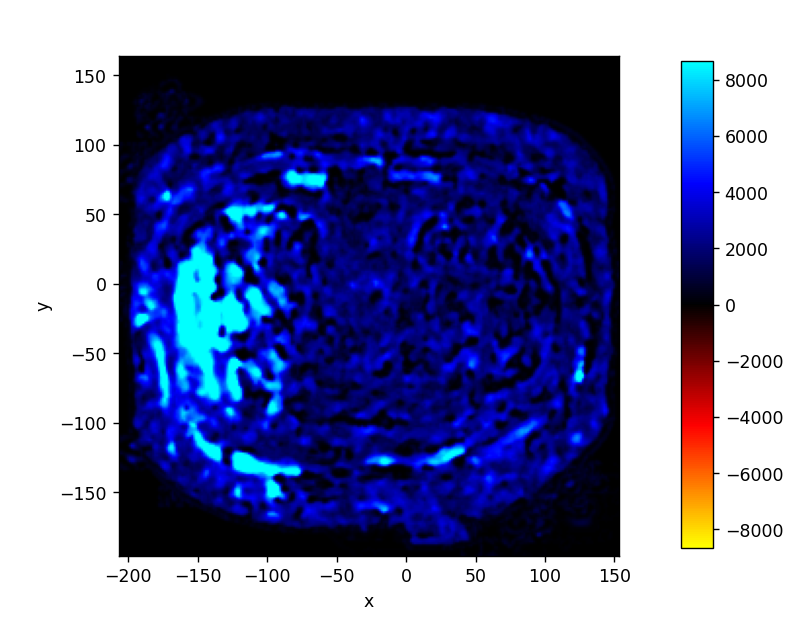

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


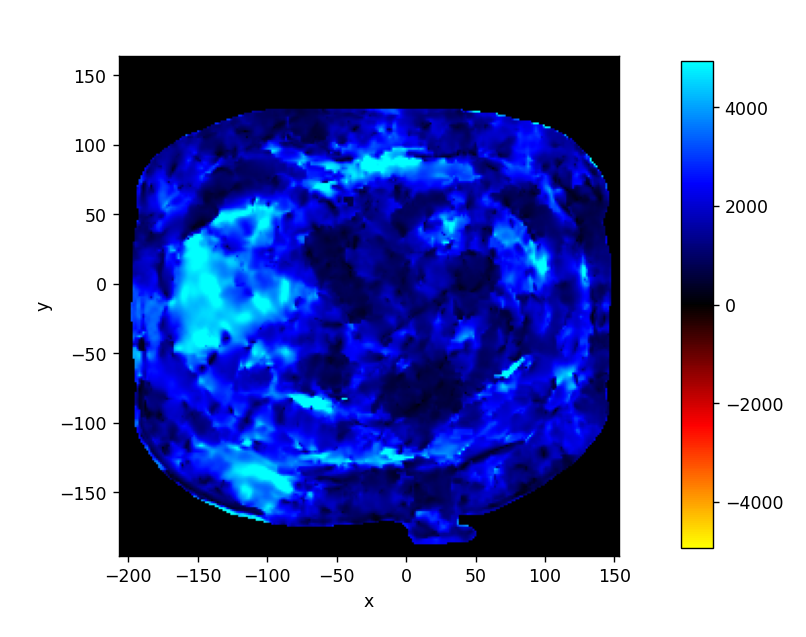

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [4]:
%autoreload
cohort[0].eval_baseline(order=3, kernel_size=5)
cohort[0].view(['Kwave', 'Lwave', 'Mwave', 'mre'])

In [5]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', rho=1e6, detach=True)
pde

In [9]:
%autoreload

pino = mre_pinn.model.pino.HyperCNN(
    n_channels_in=1,
    n_channels_block=16,
    n_conv_per_block=1,
    n_conv_blocks=5,
    width_factor=2,
    activ_fn='g',
    n_latent=128,
    n_pinn_layers=4,
    n_pinn_hidden=16,
    u_omega=16,
    u_scale=1e2,
    u_loc=0,
    mu_omega=8,
    mu_scale=1e3,
    mu_loc=0,
    skip_connect=True,
    dense=True,
    debug=True
)
pino

input		 1 [256 256   4]
conv_in		 16 [256 256   4]
conv_block0	 16 [256 256   4]
pool0		 16 [128 128   2]
conv_block1	 32 [128 128   2]
pool1		 32 [64 64  1]
conv_block2	 64 [64 64  1]
pool2		 64 [32 32  1]
conv_block3	 128 [32 32  1]
pool3		 128 [16 16  1]
conv_block4	 256 [16 16  1]
pool4		 256 [8 8 1]
linear_out	 128
input		 1 [256 256   4]
conv_in		 16 [256 256   4]
conv_block0	 16 [256 256   4]
pool0		 16 [128 128   2]
conv_block1	 32 [128 128   2]
pool1		 32 [64 64  1]
conv_block2	 64 [64 64  1]
pool2		 64 [32 32  1]
conv_block3	 128 [32 32  1]
pool3		 128 [16 16  1]
conv_block4	 256 [16 16  1]
pool4		 256 [8 8 1]
linear_out	 128


HyperCNN(
  (u_cnn): CNN(
    (conv_in): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_block0): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool0): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block2): ConvBlock(
      (conv0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool2): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block3): ConvBlock(
      (conv0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool3): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block4): ConvBlock(
      (conv0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1,

In [10]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-5,
    loss_weights=[1e-2, 0, 0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)

Compiling model...
'compile' took 0.000299 s



Training model...

0         [1.42e+02, 0.00e+00, 0.00e+00]    [1.42e+02, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


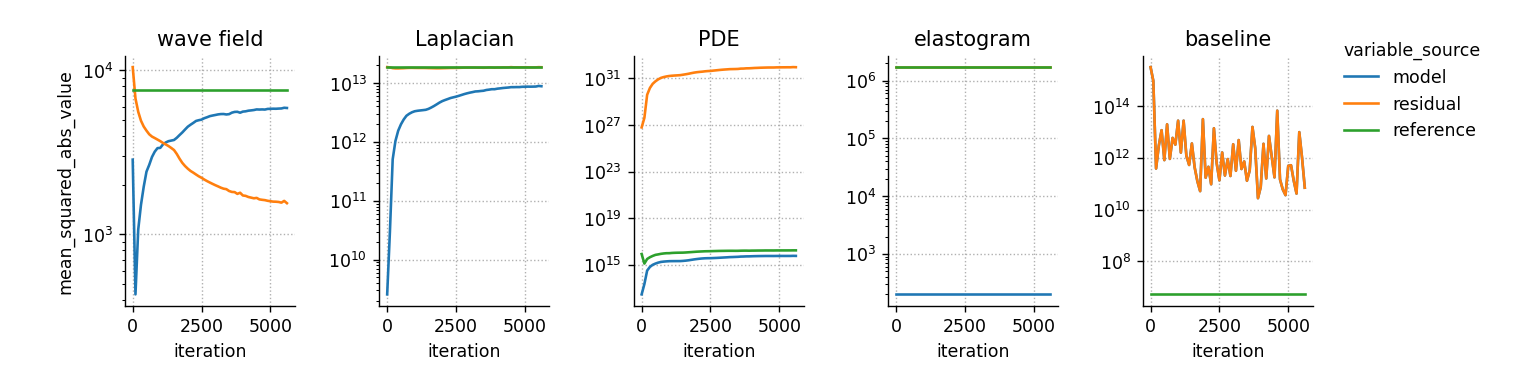

<IPython.core.display.Javascript object>


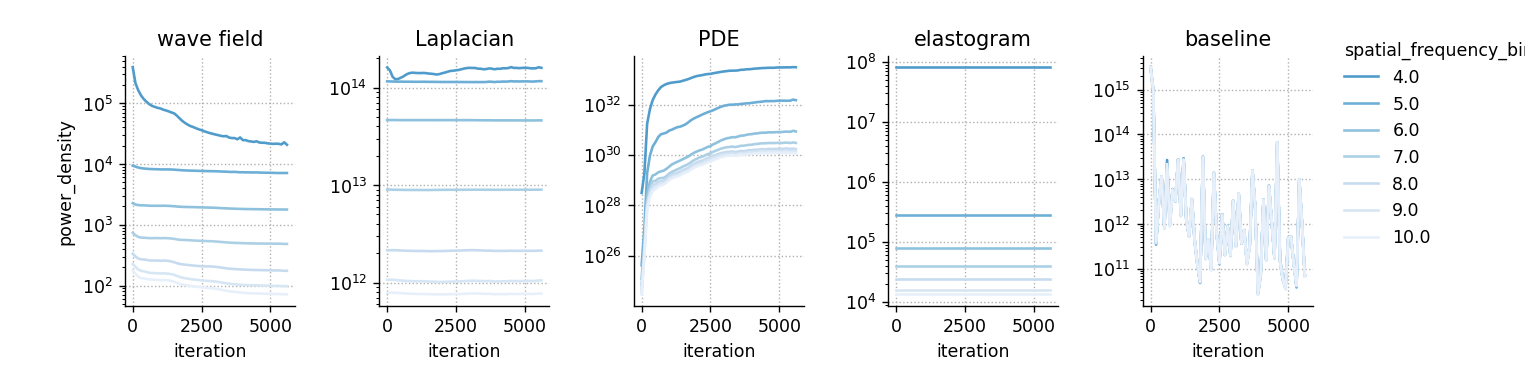

<IPython.core.display.Javascript object>


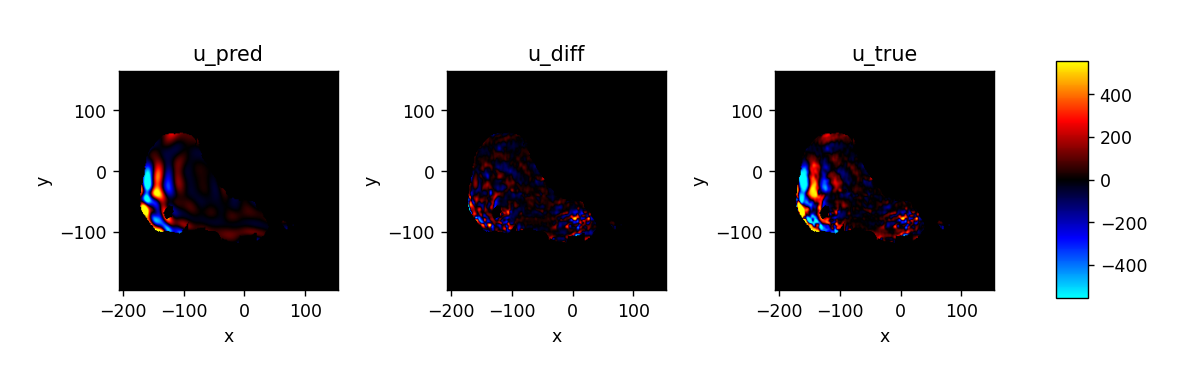

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


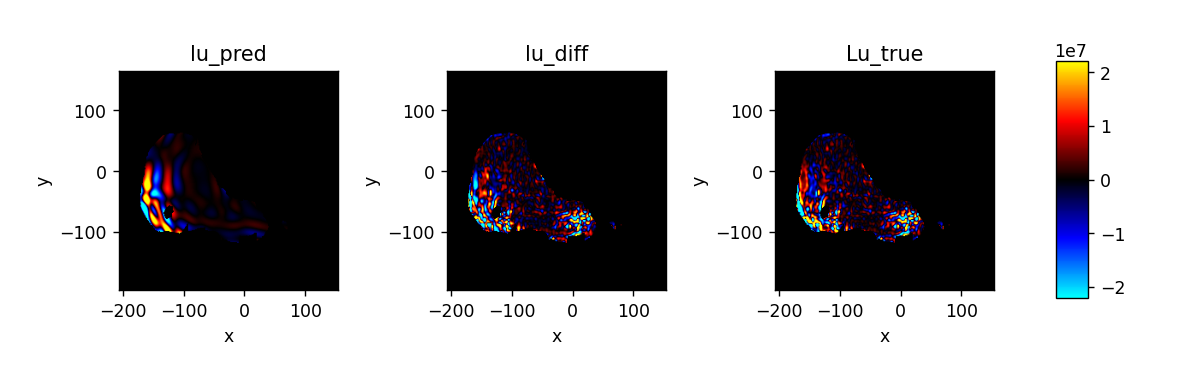

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


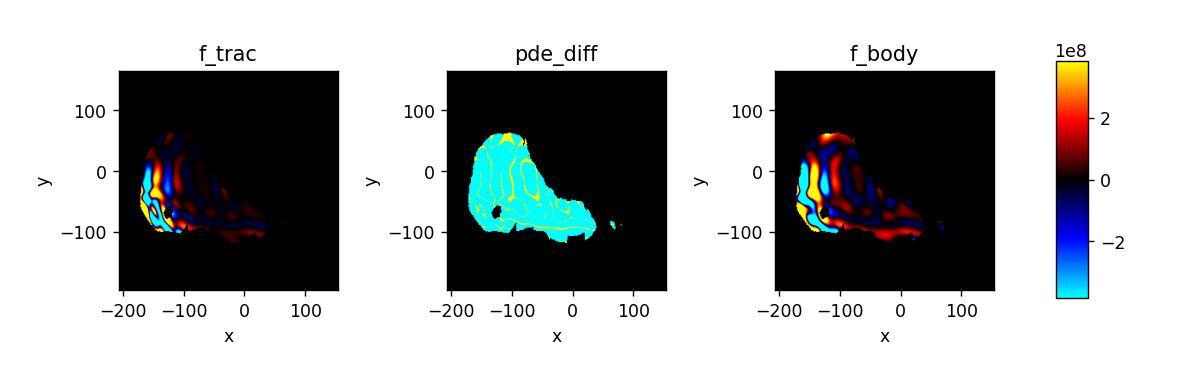

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


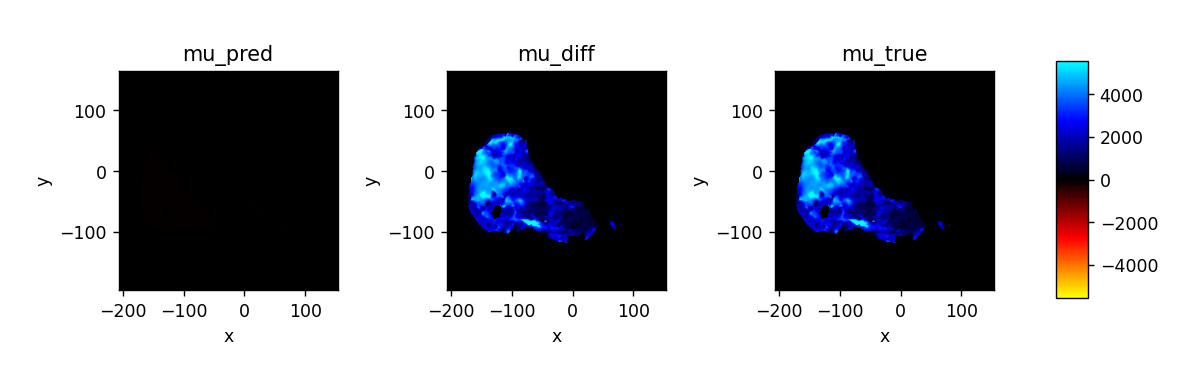

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


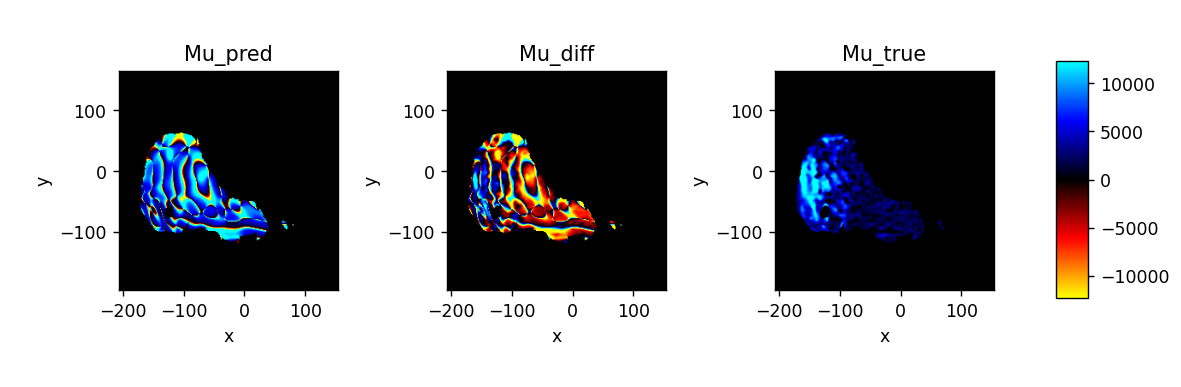

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

10        [7.95e+01, 0.00e+00, 0.00e+00]    [7.95e+01, 0.00e+00, 0.00e+00]    []  
20        [7.61e+01, 0.00e+00, 0.00e+00]    [7.61e+01, 0.00e+00, 0.00e+00]    []  
30        [7.49e+01, 0.00e+00, 0.00e+00]    [7.49e+01, 0.00e+00, 0.00e+00]    []  
40        [7.43e+01, 0.00e+00, 0.00e+00]    [7.43e+01, 0.00e+00, 0.00e+00]    []  
50        [7.38e+01, 0.00e+00, 0.00e+00]    [7.38e+01, 0.00e+00, 0.00e+00]    []  
60        [7.32e+01, 0.00e+00, 0.00e+00]    [7.32e+01, 0.00e+00, 0.00e+00]    []  
70        [7.23e+01, 0.00e+00, 0.00e+00]    [7.23e+01, 0.00e+00, 0.00e+00]    []  
80        [7.10e+01, 0.00e+00, 0.00e+00]    [7.10e+01, 0.00e+00, 0.00e+00]    []  
90        [6.92e+01, 0.00e+00, 0.00e+00]    [6.92e+01, 0.00e+00, 0.00e+00]    []  
Time spent testing: 46.51%
100       [6.67e+01, 0.00e+00, 0.00e+00]    [6.67e+01, 0.00e+00, 0.00e+00]    []  
110       [6.40e+01, 0.00e+00, 0.00e+00]    [6.40e+01, 0.00e+00, 0.00e+00]    []  
120       [6.29e+01, 0.00e+00, 0.00e+00]    [6.29e+01, 0.00e

970       [3.70e+01, 0.00e+00, 0.00e+00]    [3.70e+01, 0.00e+00, 0.00e+00]    []  
980       [4.02e+01, 0.00e+00, 0.00e+00]    [4.02e+01, 0.00e+00, 0.00e+00]    []  
990       [3.79e+01, 0.00e+00, 0.00e+00]    [3.79e+01, 0.00e+00, 0.00e+00]    []  
Time spent testing: 44.65%
1000      [3.69e+01, 0.00e+00, 0.00e+00]    [3.69e+01, 0.00e+00, 0.00e+00]    []  
1010      [3.67e+01, 0.00e+00, 0.00e+00]    [3.67e+01, 0.00e+00, 0.00e+00]    []  
1020      [3.67e+01, 0.00e+00, 0.00e+00]    [3.67e+01, 0.00e+00, 0.00e+00]    []  
1030      [3.66e+01, 0.00e+00, 0.00e+00]    [3.66e+01, 0.00e+00, 0.00e+00]    []  
1040      [3.65e+01, 0.00e+00, 0.00e+00]    [3.65e+01, 0.00e+00, 0.00e+00]    []  
1050      [3.64e+01, 0.00e+00, 0.00e+00]    [3.64e+01, 0.00e+00, 0.00e+00]    []  
1060      [3.63e+01, 0.00e+00, 0.00e+00]    [3.63e+01, 0.00e+00, 0.00e+00]    []  
1070      [3.62e+01, 0.00e+00, 0.00e+00]    [3.62e+01, 0.00e+00, 0.00e+00]    []  
1080      [3.62e+01, 0.00e+00, 0.00e+00]    [3.62e+01, 0.00e

1930      [2.75e+01, 0.00e+00, 0.00e+00]    [2.75e+01, 0.00e+00, 0.00e+00]    []  
1940      [2.64e+01, 0.00e+00, 0.00e+00]    [2.64e+01, 0.00e+00, 0.00e+00]    []  
1950      [2.60e+01, 0.00e+00, 0.00e+00]    [2.60e+01, 0.00e+00, 0.00e+00]    []  
1960      [2.57e+01, 0.00e+00, 0.00e+00]    [2.57e+01, 0.00e+00, 0.00e+00]    []  
1970      [2.56e+01, 0.00e+00, 0.00e+00]    [2.56e+01, 0.00e+00, 0.00e+00]    []  
1980      [2.55e+01, 0.00e+00, 0.00e+00]    [2.55e+01, 0.00e+00, 0.00e+00]    []  
1990      [2.54e+01, 0.00e+00, 0.00e+00]    [2.54e+01, 0.00e+00, 0.00e+00]    []  
Time spent testing: 44.56%
2000      [2.54e+01, 0.00e+00, 0.00e+00]    [2.54e+01, 0.00e+00, 0.00e+00]    []  
2010      [2.53e+01, 0.00e+00, 0.00e+00]    [2.53e+01, 0.00e+00, 0.00e+00]    []  
2020      [2.52e+01, 0.00e+00, 0.00e+00]    [2.52e+01, 0.00e+00, 0.00e+00]    []  
2030      [2.52e+01, 0.00e+00, 0.00e+00]    [2.52e+01, 0.00e+00, 0.00e+00]    []  
2040      [2.54e+01, 0.00e+00, 0.00e+00]    [2.54e+01, 0.00e

2890      [2.03e+01, 0.00e+00, 0.00e+00]    [2.03e+01, 0.00e+00, 0.00e+00]    []  
Time spent testing: 44.57%
2900      [2.03e+01, 0.00e+00, 0.00e+00]    [2.03e+01, 0.00e+00, 0.00e+00]    []  
2910      [2.03e+01, 0.00e+00, 0.00e+00]    [2.03e+01, 0.00e+00, 0.00e+00]    []  
2920      [2.02e+01, 0.00e+00, 0.00e+00]    [2.02e+01, 0.00e+00, 0.00e+00]    []  
2930      [2.02e+01, 0.00e+00, 0.00e+00]    [2.02e+01, 0.00e+00, 0.00e+00]    []  
2940      [2.03e+01, 0.00e+00, 0.00e+00]    [2.03e+01, 0.00e+00, 0.00e+00]    []  
2950      [2.06e+01, 0.00e+00, 0.00e+00]    [2.06e+01, 0.00e+00, 0.00e+00]    []  
2960      [2.04e+01, 0.00e+00, 0.00e+00]    [2.04e+01, 0.00e+00, 0.00e+00]    []  
2970      [2.01e+01, 0.00e+00, 0.00e+00]    [2.01e+01, 0.00e+00, 0.00e+00]    []  
2980      [2.00e+01, 0.00e+00, 0.00e+00]    [2.00e+01, 0.00e+00, 0.00e+00]    []  
2990      [2.00e+01, 0.00e+00, 0.00e+00]    [2.00e+01, 0.00e+00, 0.00e+00]    []  
Time spent testing: 44.58%
3000      [1.99e+01, 0.00e+00, 0.

3850      [1.75e+01, 0.00e+00, 0.00e+00]    [1.75e+01, 0.00e+00, 0.00e+00]    []  
3860      [1.75e+01, 0.00e+00, 0.00e+00]    [1.75e+01, 0.00e+00, 0.00e+00]    []  
3870      [1.74e+01, 0.00e+00, 0.00e+00]    [1.74e+01, 0.00e+00, 0.00e+00]    []  
3880      [1.76e+01, 0.00e+00, 0.00e+00]    [1.76e+01, 0.00e+00, 0.00e+00]    []  
3890      [1.78e+01, 0.00e+00, 0.00e+00]    [1.78e+01, 0.00e+00, 0.00e+00]    []  
Time spent testing: 44.60%
3900      [1.79e+01, 0.00e+00, 0.00e+00]    [1.79e+01, 0.00e+00, 0.00e+00]    []  
3910      [1.75e+01, 0.00e+00, 0.00e+00]    [1.75e+01, 0.00e+00, 0.00e+00]    []  
3920      [1.74e+01, 0.00e+00, 0.00e+00]    [1.74e+01, 0.00e+00, 0.00e+00]    []  
3930      [1.73e+01, 0.00e+00, 0.00e+00]    [1.73e+01, 0.00e+00, 0.00e+00]    []  
3940      [1.73e+01, 0.00e+00, 0.00e+00]    [1.73e+01, 0.00e+00, 0.00e+00]    []  
3950      [1.73e+01, 0.00e+00, 0.00e+00]    [1.73e+01, 0.00e+00, 0.00e+00]    []  
3960      [1.73e+01, 0.00e+00, 0.00e+00]    [1.73e+01, 0.00e

4810      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4820      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4830      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4840      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4850      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4860      [1.63e+01, 0.00e+00, 0.00e+00]    [1.63e+01, 0.00e+00, 0.00e+00]    []  
4870      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
4880      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
4890      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
Time spent testing: 44.64%
4900      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
4910      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4920      [1.65e+01, 0.00e+00, 0.00e+00]    [1.65e+01, 0.00e

KeyboardInterrupt: 

In [11]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

model.train(100000, display_every=10, callbacks=[test_eval])